# -*- coding: utf-8 -*-
"""
Created on Wed Mar 26 11:55:40 2025

@author: mrsag
"""

Simulation of Thomson parabola for given 
1. Electric field (E) (taken from V/d)
2. Magnetic Field (B)
3. Electric field length (lE)
4. Magnetic field length (lB)
5. Distance of screen from electric field region endpoint (DE)
6. Distance of screen from magnetic field region endpoint (DB)
7. Charge of the particle in terms of proton charge (q)
8. Mass of particle (in terms of electron mass)

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import scipy.integrate as integrate
from Curve_fitting_with_scipy import polynomial_fit as pft
import glob

import matplotlib as mpl
mpl.rcParams['font.family'] = 'serif'
mpl.rcParams['font.serif'] = 'Times New Roman'
mpl.rcParams['font.size'] = 12
#mpl.rcParams['font.weight'] = 'bold'
#mpl.rcParams['font.style'] = 'italic'  # Set this to 'italic'
mpl.rcParams['figure.dpi']=300 # highres display

In [75]:
# Defining constants:
cm = 1e-2
mm = 1e-3
e = 1.6e-19
me = 9.11e-31
keV_to_Joule = 1.6e-16

In [76]:
# Input parameters:

V = 12000 # Potential difference in between the cathode and anode (V)   (in Volts)
d = 1.3*cm # distance over which the electric field is being applied (in cm)
E_field = V/d # electric field (in Volts/m))
B_field = 0.45 # Magnetic Field (B)  (in Tesla)
lE = 12*cm # Electric field length (lE)  (in cm)
lB = 5*cm  # Magnetic field length (lB)  (in cm)
DE = 18.8*cm # Distance of screen from electric field region endpoint (DE)  (in cm)
DB = (32.3+1.75)*cm # Distance of screen from magnetic field region endpoint (DB)  (in cm)
q = 1*e # Charge of the particle in terms of proton charge (q)
m = 1836*me # Mass of particle (in terms of electron mass)


In [77]:
class particle():
    def __init__(self,x,y,z,vx,vy,vz,q,m):
        self.x = x
        self.y = y
        self.z = z
        self.vx = vx
        self.vy = vy
        self.vz = vz
        self.q = q
        self.m = m
        self.v = np.sqrt(vx**2+vy**2+vz**2)
        self.Energy = m*self.v**2/2
    

    def propagator(self):
        global t
        global dt
        global B_field
        global E_field
        global DE
        global DB
        global lE
        global lB

        broke = False

        for i in range(len(t)):
            if(self.z>=0):
                broke = True
                break
            
            if(DE+lE>=abs(self.z)>DE):
                E = E_field
            else:
                E = 0
            if(DB+lB>=abs(self.z)>DB):
                B = B_field
            else:
                B = 0

            Fx = self.q*E
            Fy = self.q*self.vz*B
            Fz = -self.q*self.vy*B

            ax,ay,az = Fx/self.m, Fy/self.m, Fz/self.m

            self.x += self.vx*dt + ax*dt**2/2
            self.y += self.vy*dt + ay*dt**2/2
            self.z += self.vz*dt + az*dt**2/2

            self.vx += ax*dt
            self.vy += ay*dt
            self.vz += az*dt


            self.v = np.sqrt(self.vx**2+self.vy**2+self.vz**2)
            self.E = self.m*self.v**2/2

        if broke:
            return self.x,self.y,self.z  #,self.z,self.E,self.v
        else:
            return np.nan,np.nan,self.z

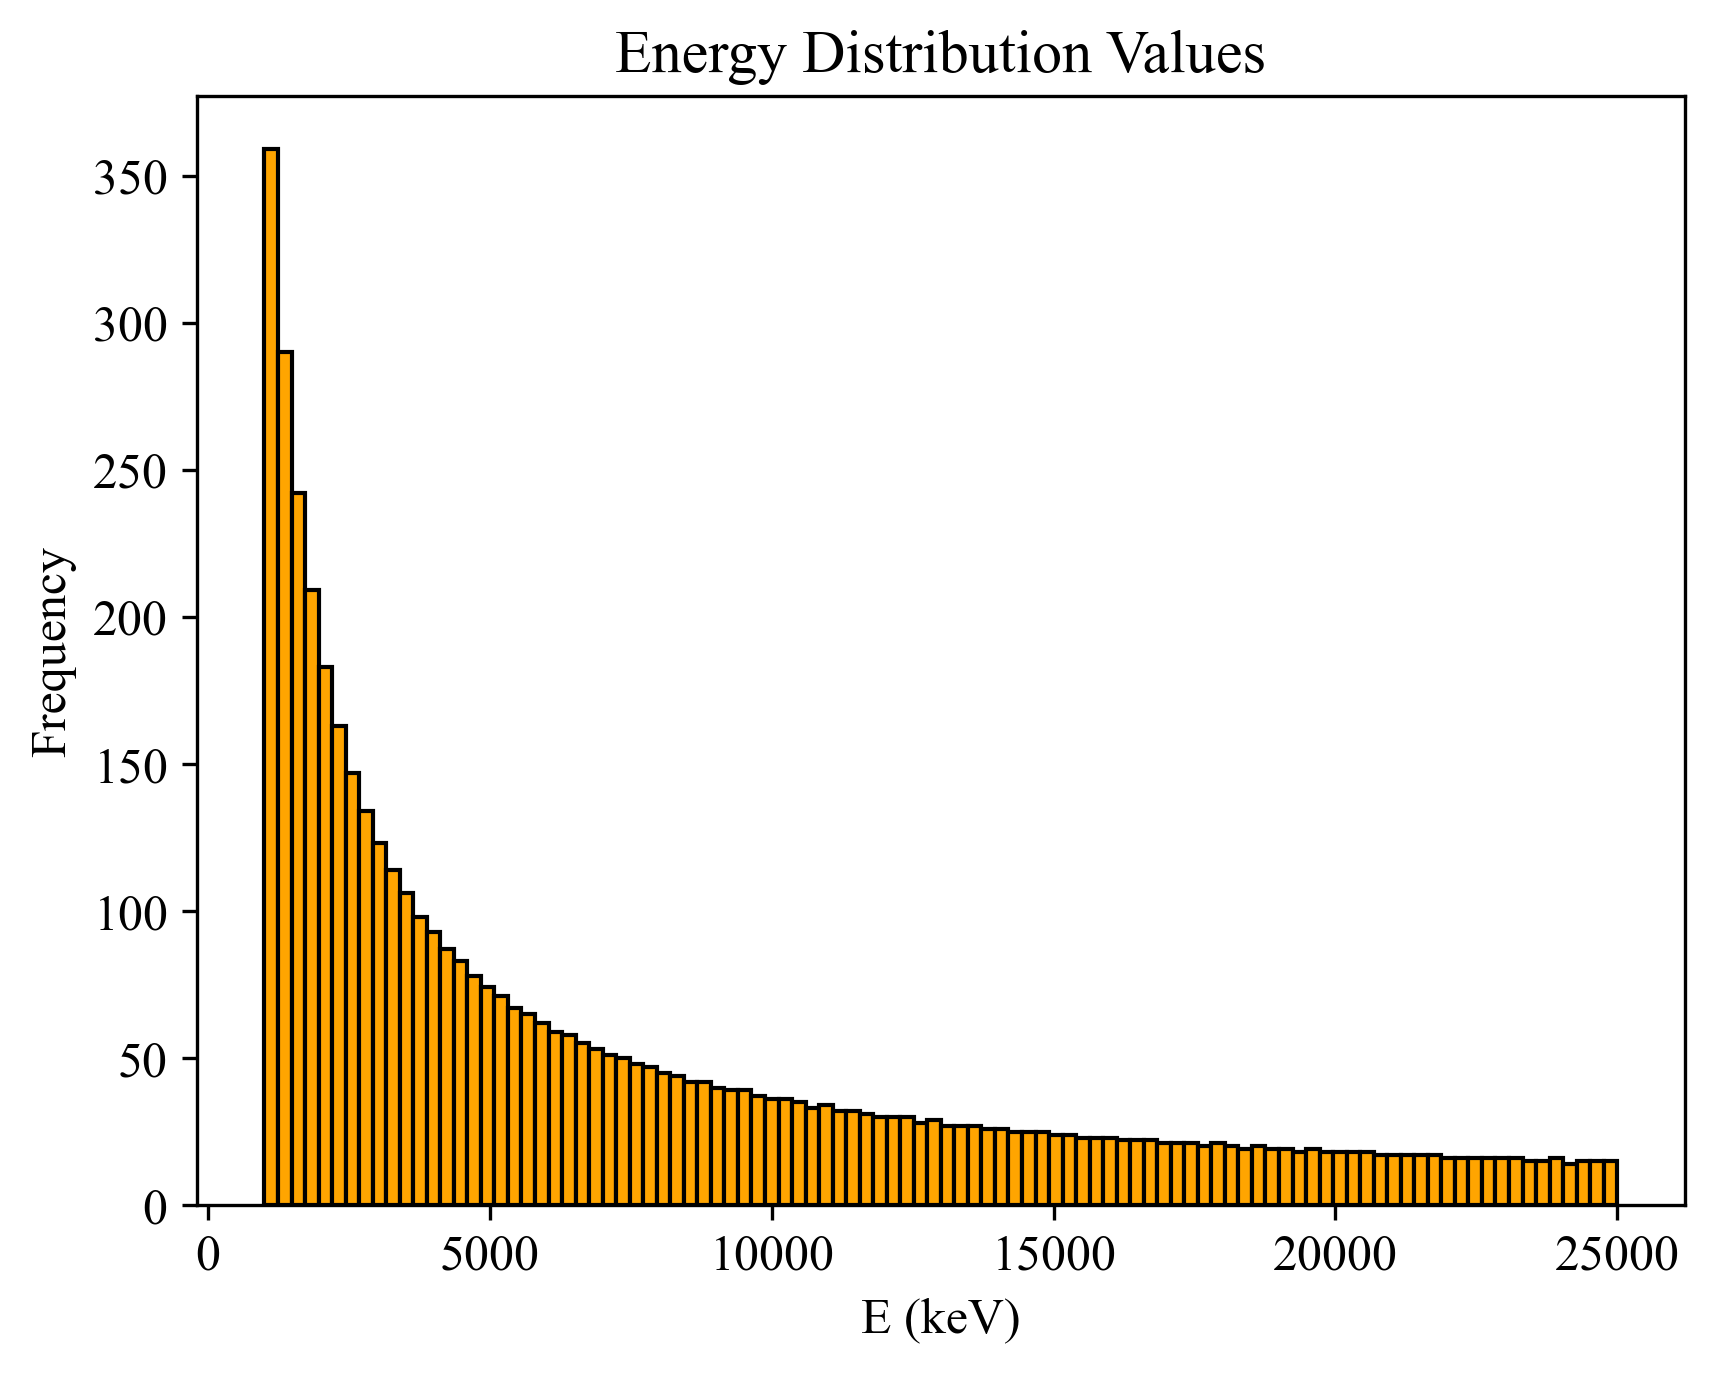

In [78]:
# Parameters
low_energy  = 1000
high_energy = 25000
size = 5000 
steep = 3.0  # Smaller = sharper drop-off near 500

# Generate raw exponential values
raw = np.linspace(0,10,size)
# Normalize to [0, 1]
raw = np.exp(-raw/steep)

M1 = np.array([[low_energy, (high_energy-low_energy)],
                [low_energy, raw[-1]*(high_energy-low_energy)]])

b = np.array([high_energy,low_energy])

sol = np.linalg.solve(M1,b)
alpha = sol[0]
beta = sol[1]

# Scale to [500, 40000]
Energy = (alpha*low_energy + beta * raw * (high_energy - low_energy))*keV_to_Joule 


# Energy = np.random.uniform(low=500,high=30000,size=10000)*keV_to_Joule  # Energy of the particle (in keV)
v = np.sqrt(2*Energy/m) # calculates in Si unit

x = 0
y = 0
z = -max([lE+DE,lB+DB])

vx = 0
vy = 0
vz = v

time_resolution = 15000
t_max = 50*max([lE+DE,lB+DB])/min(v)
t = np.linspace(0,t_max,time_resolution)
dt = np.diff(t)[0]


plt.hist(Energy/keV_to_Joule, bins=100, color='orange', edgecolor='black')
plt.title("Energy Distribution Values")
plt.xlabel("E (keV)")
plt.ylabel("Frequency")
plt.show()

In [79]:
sx = [0]
sy = [0]
sz = [0]
sE = [0]
for i in range(len(Energy)):
    p = particle(x,y,z,vx,vy,vz[i],q,m)
    dx,dy,dz = p.propagator()

    if(dx!= np.nan or dy!= np.nan):
        sx.append(dx/mm)
        sy.append(dy/mm)
        sz.append(dz/mm)
        sE.append(p.Energy)

sE[0] = np.max(sE)*1.5


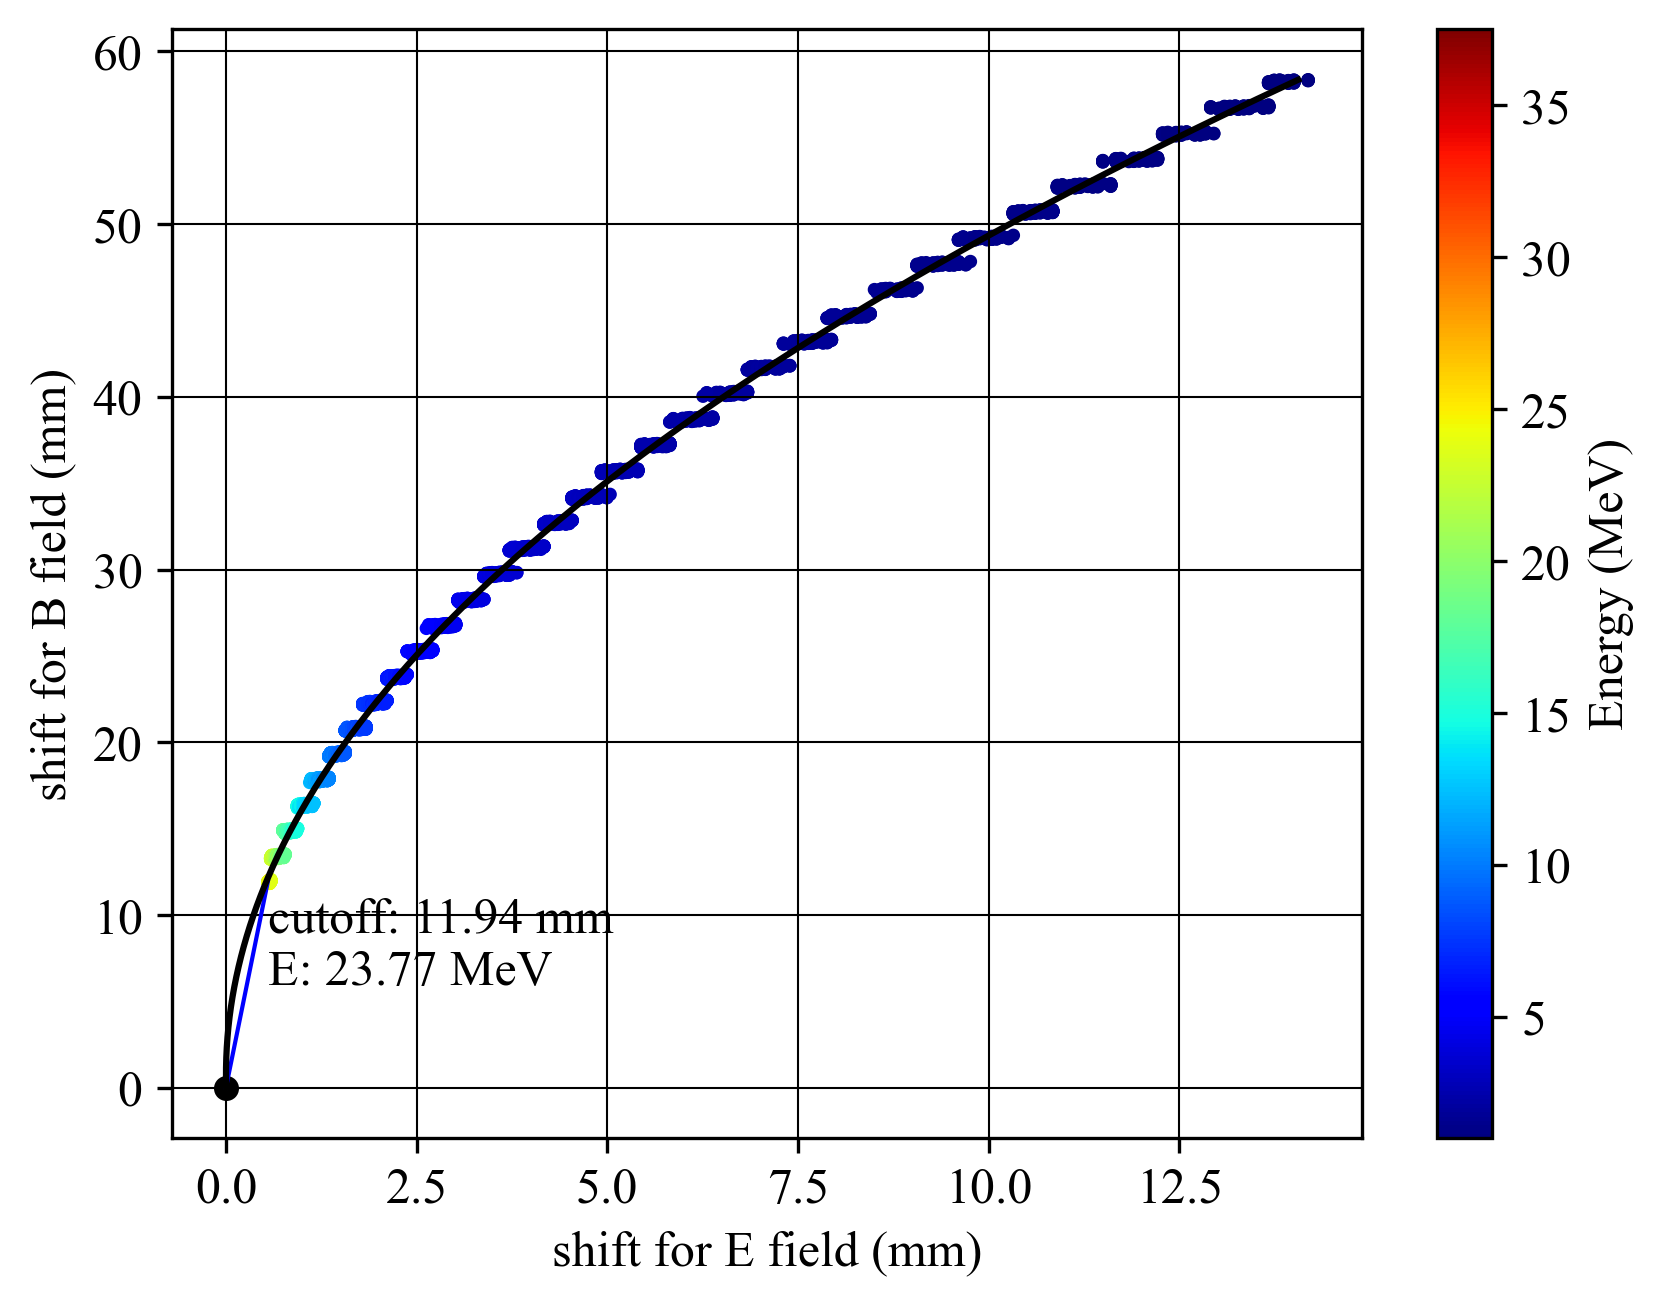

In [80]:
sx,sy,sE = np.array(sx),np.array(sy),np.array(sE)
# Get sorted indices of x
sorted_indices = np.argsort(sx)

# Apply the same indices to all arrays
sx = sx[sorted_indices]
sy = sy[sorted_indices]
sE = sE[sorted_indices]

coeffs = np.polyfit(sy, sx, 2)  # Quadratic fit

x_parabola = np.linspace(np.min(sy),np.max(sy),1000)
y_parabola = np.polyval(coeffs, x_parabola)


cutoff_DE = sx[1]
cutoff_DB = sy[1]
cutoff_D = np.sqrt(sx[1]**2 + sy[1]**2)
cutoff_E = sE[1]/keV_to_Joule/1000


plt.scatter(sx,sy,c=np.array(sE)/keV_to_Joule/1000,s=5,cmap="jet")
# plt.hist(sE[1:]/keV_to_Joule/1000,weights = np.ones_like(sE[1:])/np.histogram(sE[1:], bins=100)[0].max()*np.max(sy),bins=100)
plt.plot(sx[:1],sy[:1],"ko",markersize=5)
plt.plot(sx[:2],sy[:2],"b-",lw=1)
plt.text(x=sx[1],y=sy[1]/2,s=f"cutoff: {np.sqrt(sx[1]**2+sy[1]**2):.2f} mm\nE: {sE[1]/keV_to_Joule/1000 :.2f} MeV")
plt.plot(y_parabola,x_parabola,"k-")
plt.grid(lw=0.5,color="k")
plt.colorbar(label = "Energy (MeV)")
plt.xlabel("shift for E field (mm)")
plt.ylabel("shift for B field (mm)")
plt.show()

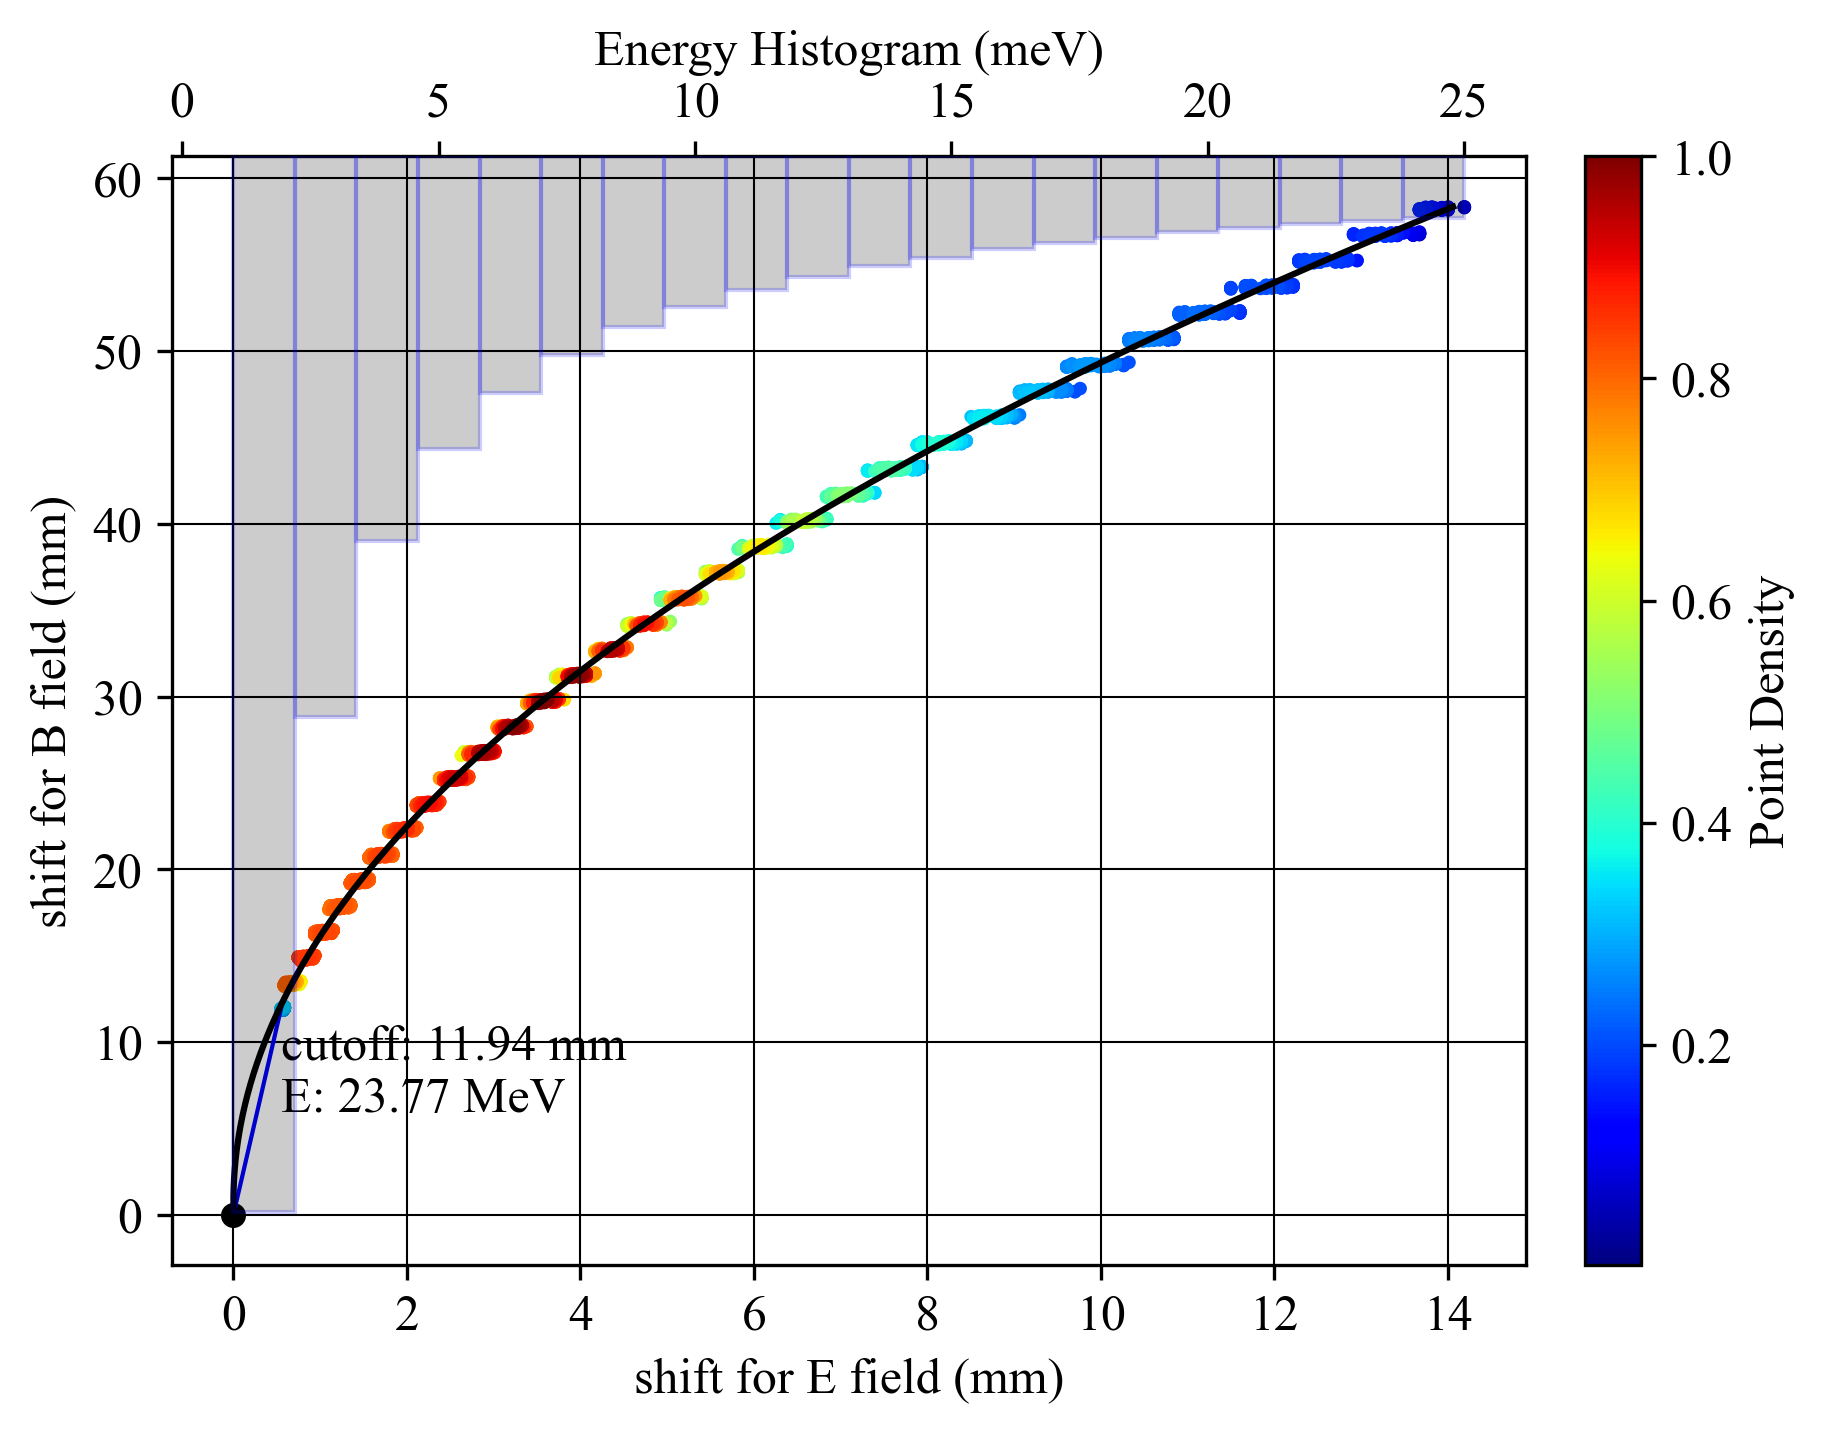

In [81]:
from scipy.stats import gaussian_kde


fig, ax1 = plt.subplots()

# Calculate the density of the points
xy = np.vstack([sx, sy])
z = gaussian_kde(xy)(xy)  # Get density for each point

# Sort points by density for better visibility
idx = z.argsort()
sx, sy, z = sx[idx], sy[idx], z[idx]
z = np.array(z)/max(z)

# Main scatter plot (with density-based coloring)
sc = ax1.scatter(sx, sy, c=z, s=5, cmap="jet")
ax1.plot([0], [0], "ko", markersize=5)
ax1.plot([0,cutoff_DE], [0,cutoff_DB], "b-", lw=1)
ax1.text(x=cutoff_DE, y=cutoff_DB/2,
         s=f"cutoff: {cutoff_D:.2f} mm\nE: {cutoff_E :.2f} MeV")
ax1.plot(y_parabola, x_parabola, "k-")
ax1.grid(lw=0.5, color="k")

# Add colorbar
cbar = fig.colorbar(sc, ax=ax1,fraction=0.05, pad=0.04)
cbar.set_label("Point Density")

ax1.set_xlabel("shift for E field (mm)")
ax1.set_ylabel("shift for B field (mm)")

# Create a new inset axes on top, same width, no shared y
ax2 = fig.add_axes(ax1.get_position(), frameon=False)
ax2.set_facecolor("none")

# Calculate histogram data
hist_vals, bin_edges = np.histogram(sE[1:]/keV_to_Joule/1000, bins=20)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
weights = hist_vals / hist_vals.max()

# Plot histogram as bars
ax2.bar(bin_centers, weights, width=bin_edges[1] - bin_edges[0],
        color="k", edgecolor="blue", alpha=0.2)

# Invert y-axis only for ax2
ax2.invert_yaxis()

# Hide x-axis of ax2
ax2.xaxis.set_ticks_position('top')
ax2.xaxis.set_label_position('top')
ax2.set_xlabel("Energy Histogram (meV)")

# Show y-axis only on the right
ax2.tick_params(axis='y', which='both', left=False, right=False, labelleft=False)
ax2.yaxis.set_label_position("right")

# Hide background elements of ax2
ax2.spines['left'].set_visible(False)
ax2.spines['bottom'].set_visible(False)
ax2.spines['right'].set_visible(True)
ax2.spines['top'].set_visible(True)

plt.show()